In [48]:
import pandas as pd
# Load Data
url = 'https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/dataset/mulestudio.csv'
raw_data = pd.read_csv(url)
raw_data.columns
raw_data.head(6)

,issuekey,title,description,storypoint
0,STUDIO-95,Support for request/reply,request/reply http://www.mulesoft.org/documen...,13
1,STUDIO-280,Cannot import a Studio project from Git withou...,Steps to reproduce: 1. Create a simple Mule...,3
2,STUDIO-382,Changes to Java code do not get hot deployed,Java source changes don't get picked up right ...,5
3,STUDIO-459,Unable to add a response when creating a secon...,Unable to add a response when creating a secon...,8
4,STUDIO-618,Namespaces in the XML view are not being remo...,When you add an element and then you remove it...,8
5,STUDIO-781,Would save time to be given the option to crea...,Add a button in the ClassFieldEditor to create...,5


In [49]:
# Check for missing values
raw_data.isnull().sum()


issuekey       0
title          0
description    0
storypoint     0
dtype: int64

In [50]:

# Examine storypoints summary statistics
raw_data.storypoint.describe()

count    732.000000
mean       6.396175
std        5.385687
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       34.000000
Name: storypoint, dtype: float64

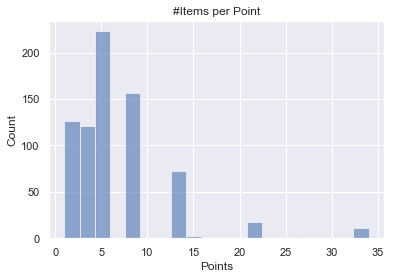

In [51]:
# Visualize number of storypoints distribution
import matplotlib.pyplot as plt
plt.hist(raw_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.show()


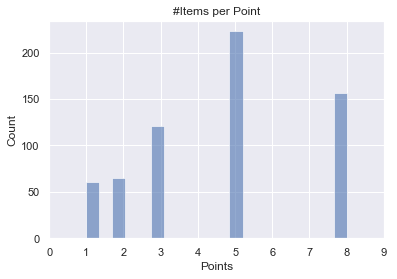

In [52]:
# Zoom in on most common data representing 75% of the dataset
import numpy as np
frequent_data = raw_data.query('storypoint <= 8')
plt.hist(frequent_data.storypoint, bins=20, alpha=0.6, color='b')
plt.title("#Items per Point")
plt.xlabel("Points")
plt.ylabel("Count")
plt.xticks(np.arange(0, 10, 1)) 
plt.show()

In [53]:
raw_data.loc[raw_data.storypoint <= 3, 'storypoint'] = 0 #small
raw_data.loc[(raw_data.storypoint > 3) & (raw_data.storypoint <= 9), 'storypoint'] = 1 #medium
raw_data.loc[raw_data.storypoint > 9, 'storypoint'] = 2 #big

In [54]:
# Examine distribution in detail
raw_data.groupby('storypoint').size()

storypoint
0    247
1    380
2    105
dtype: int64

This shows that 5 the most common number of storypoints assigned to an issue/requirement.

In [55]:
################### Data Preprocessing ###################################

import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download('stopwords')

issue_titles = raw_data['title']
issue_descriptions = raw_data['description']

# Create a list of strings, one for each title
titles_list = [title for title in issue_titles]
descriptions_list = [description for description in issue_descriptions]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]





[nltk_data] Downloading package punkt to /home/eliska/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eliska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
import gensim
# Load word2vec model (trained on Google corpus)
model = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary = True) 

# Check dimension of word vectors
model.vector_size

300

In [57]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
load,0.279297,0.220703,-0.023071,0.025879,0.090820,-0.130859,0.086426,-0.023071,0.097656,0.115723,...,-0.118652,0.253906,0.063477,0.122559,-0.148438,0.210938,-0.182617,-0.133789,-0.221680,-0.075195
containing,0.119141,0.004028,0.130859,-0.021362,-0.042236,-0.141602,-0.059326,-0.102051,-0.037842,0.314453,...,-0.084961,-0.257812,0.138672,0.144531,-0.003235,-0.051270,-0.100586,-0.019775,-0.096191,-0.119629
schemas,0.016113,-0.176758,0.021729,-0.016602,-0.406250,0.126953,0.176758,0.232422,0.033691,0.214844,...,-0.287109,0.273438,0.185547,0.034912,-0.194336,0.110352,0.421875,-0.161133,-0.037842,0.337891


In [58]:
# Vocabulary
vocabulary = set(words) # list of unique words
vocabulary_size = len(vocabulary)
vocabulary_size

1270

In [59]:
# Total Number of Words
len(words)



4531

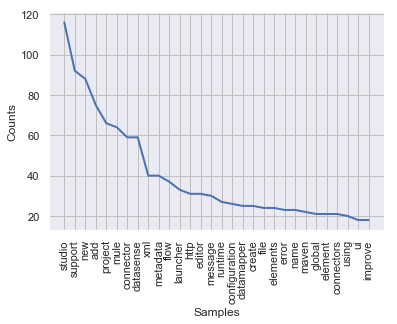

In [60]:
# Frequency Distribution of Words Plot
from nltk.probability import FreqDist
fdist = FreqDist(words)
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

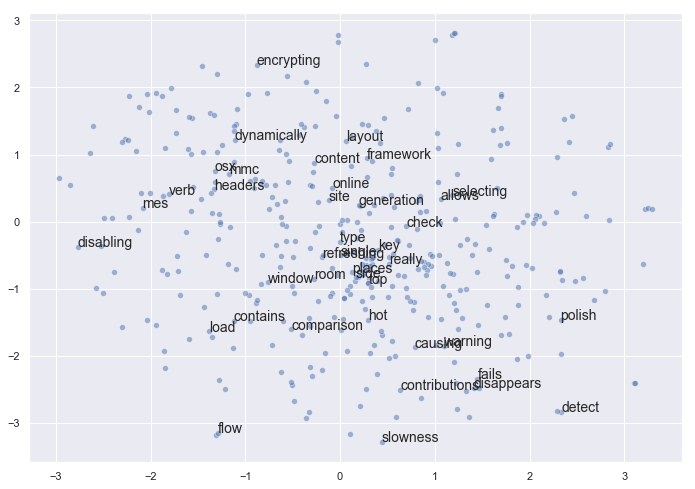

In [61]:
# Dimentionality Reduction
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

# Plot
import seaborn as sns
sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
#from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
'''
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
'''
plt.show()

In [62]:
raw_data['storypoint']

0      2
1      0
2      1
3      1
4      1
5      1
6      1
7      1
8      2
9      1
10     0
11     2
12     1
13     1
14     1
15     1
16     1
17     1
18     0
19     2
20     1
21     2
22     0
23     1
24     1
25     1
26     1
27     1
28     1
29     0
      ..
702    1
703    2
704    2
705    2
706    1
707    2
708    2
709    2
710    1
711    1
712    1
713    0
714    1
715    0
716    1
717    1
718    1
719    1
720    0
721    0
722    0
723    0
724    0
725    0
726    0
727    0
728    1
729    1
730    0
731    1
Name: storypoint, Length: 732, dtype: int64

In [63]:
# Averaging Word Embeddings
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

In [64]:
raw_data['storypoint'][0]

2

In [65]:
# Preprocess the corpus
def preprocessing(data_list):
  corpus = [preprocess(title) for title in data_list]

  # Remove docs that don't include any words in W2V's vocab
  corpus, data_list = filter_docs(corpus, data_list, lambda doc: has_vector_representation(model, doc))

  # Filter out any empty docs
  corpus, data_list = filter_docs(corpus, data_list, lambda doc: (len(doc) != 0))

  y = []
  x = []
  for doc in corpus: # append the vector for each document
      #print(corpus.index(doc))
      x.append(document_vector(model, doc))
      y.append(raw_data['storypoint'][corpus.index(doc)])
      
  X = np.array(x) # list to array
  y = np.array(y)
  return X, y


In [66]:
# Titles
X = preprocessing(titles_list)[0]
y = preprocessing(titles_list)[1]

0 docs removed
0 docs removed
0 docs removed
0 docs removed


In [67]:

# 80% of data goes to training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)


XGBRegressor - using Titles of software issues/requests as data

In [68]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Accuracy
y_pred_rounded = [round(prediction,0) for prediction in y_pred ]
y_pred_rounded = [int(prediction) for prediction in y_pred_rounded]

from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred_rounded)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.5578231292517006


GaussianNB - - using Titles of software issues/requests as data

In [69]:
# Build the classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))


Total accuracy classification score: 0.4557823129251701


Using Descriptions of sotware issues/requests as data

In [70]:
# Descriptions
X = preprocessing(descriptions_list)[0]
y = preprocessing(descriptions_list)[1]

2 docs removed
0 docs removed
2 docs removed
0 docs removed


In [71]:

# 80% of data goes to training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)


In [72]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# Instantiate an XGBRegressor
xgr = xgb.XGBRegressor(random_state=2)

# Fit the classifier to the training set
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

mean_squared_error(y_test, y_pred)

# Accuracy
y_pred_rounded = [round(prediction,0) for prediction in y_pred ]
y_pred_rounded = [int(prediction) for prediction in y_pred_rounded]

from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred_rounded)
print('Total accuracy classification score: {}'.format(acc_score))

Total accuracy classification score: 0.547945205479452


In [73]:
# Build the classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit the classifier to the training set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
from sklearn import metrics
acc_score = metrics.accuracy_score(y_test, y_pred)
print('Total accuracy classification score: {}'.format(acc_score))


Total accuracy classification score: 0.4452054794520548


In [74]:
y_pred, y_test

(array([1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0]),
 array([2, 0, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0,
        0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 1,
        0, 0, 2, 0, 1, 2, 0, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 1, 0,
        1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1]))